In [1]:
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

import cartopy.crs as ccrs
from google.cloud import storage
from graphcast import autoregressive
from graphcast import casting
from graphcast import checkpoint
from graphcast import data_utils
from graphcast import graphcast
from graphcast import normalization
from graphcast import rollout
from graphcast import xarray_jax
from graphcast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray
import his_utils

def parse_file_parts(file_name):
  return dict(part.split("-", 1) for part in file_name.split("_"))

gcs_client = storage.Client.create_anonymous_client()
gcs_bucket = gcs_client.get_bucket("dm_graphcast")
gcs_bucket

<Bucket: dm_graphcast>

### Set the model and properties

In [2]:
# initialization 
# TODO: 여기 값 바꾸면 됨 근데 모델 불러서 쓸거면 상관 없ㅅ음
resolution = 0 # 0.25 or 1.0
mesh_size = 1000 # 4~6
latent_size = 100 # 2^4 ~ 2^9
gnn_msg_steps = 10 # 1~32
pressure_levels = 37 # 13, 25, 37
hidden_layers = 1 
radius_query_fraction_edge_length = 0.6 # 1로도 가능
params = None
state = {}

In [3]:
# 모델 생성
model_config = graphcast.ModelConfig(
        resolution=resolution, 
        mesh_size=mesh_size,
        latent_size=latent_size,
        gnn_msg_steps=gnn_msg_steps,
        hidden_layers=hidden_layers,
        radius_query_fraction_edge_length=radius_query_fraction_edge_length    
    )

task_config = graphcast.TaskConfig(
        input_variables=(graphcast.TARGET_SURFACE_VARS + graphcast.TARGET_ATMOSPHERIC_VARS + graphcast.FORCING_VARS +
        graphcast.STATIC_VARS),
        target_variables=graphcast.TARGET_SURFACE_VARS + graphcast.TARGET_ATMOSPHERIC_VARS,
        forcing_variables=graphcast.FORCING_VARS,
        pressure_levels=graphcast.PRESSURE_LEVELS[pressure_levels],
        input_duration="12h"
    )

model_config

ModelConfig(resolution=0, mesh_size=1000, latent_size=100, gnn_msg_steps=10, hidden_layers=1, radius_query_fraction_edge_length=0.6, mesh2grid_edge_normalization_factor=None)

In [4]:
# 그냥 가져다 쓰고 싶으면 여기서
GC_original = 'GraphCast - ERA5 1979-2017 - resolution 0.25 - pressure levels 37 - mesh 2to6 - precipitation input and output.npz'
GC_operational = 'GraphCast_operational - ERA5-HRES 1979-2021 - resolution 0.25 - pressure levels 13 - mesh 2to6 - precipitation output only.npz'
GC_small = 'GraphCast_small - ERA5 1979-2015 - resolution 1.0 - pressure levels 13 - mesh 2to5 - precipitation input and output.npz'

# TODO: 모델 하나 골라 로드하기
pretrained_model = GC_original

with gcs_bucket.blob(f"params/{pretrained_model}").open("rb") as f:
    ckpt = checkpoint.load(f, graphcast.CheckPoint)

In [5]:

params = ckpt.params  # 로드된 체크포인트에서 파라미터 가져오기
state = {}  # 초기 상태는 빈 딕셔너리로 설정

# 체크포인트에서 모델 구성 가져오기
model_config = ckpt.model_config
# 체크포인트에서 작업 구성 가져오기
task_config = ckpt.task_config

# 모델 설명 출력
print("Model description:\n", ckpt.description, "\n")
# 모델 라이선스 출력
print("Model license:\n", ckpt.license, "\n")

print("Model config:\n", model_config, "\n")

print("Task config:\n", task_config)

Model description:
 
GraphCast model at 0.25deg resolution, with 37 pressure levels. This model is
trained on ERA5 data from 1979 to 2017, and can be causally evaluated on 2018
and later years. This model takes as inputs `total_precipitation_6hr`. This was
described in the paper
`GraphCast: Learning skillful medium-range global weather forecasting`
(https://arxiv.org/abs/2212.12794).
 

Model license:
 
The model weights are licensed under the Creative Commons
Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0). You
may obtain a copy of the License at:
https://creativecommons.org/licenses/by-nc-sa/4.0/.
The weights were trained on ERA5 data, see README for attribution statement.
 

Model config:
 ModelConfig(resolution=0.25, mesh_size=6, latent_size=512, gnn_msg_steps=16, hidden_layers=1, radius_query_fraction_edge_length=0.5999912857713345, mesh2grid_edge_normalization_factor=0.6180338738074472) 

Task config:
 TaskConfig(input_variables=('2m_temperature', 'mean_s

### Load Data

In [6]:
# 모델과 데이터셋의 유효성을 검사하는 함수
def data_valid_for_model(
    file_name: str, 
    model_config: graphcast.ModelConfig, 
    task_config: graphcast.TaskConfig):
    # 파일 이름에서 접미사 ".nc"를 제거하고 파일의 각 부분을 파싱
    file_parts = parse_file_parts(file_name.removesuffix(".nc"))
    
    # 모델의 설정과 데이터셋 파일의 설정을 비교하여 유효성 검사
    return (
        # 모델의 해상도가 0이거나 파일의 해상도와 일치해야 함
        model_config.resolution in (0, float(file_parts["res"])) and
        # 모델의 압력 레벨 수가 파일의 압력 레벨 수와 일치해야 함
        len(task_config.pressure_levels) == int(file_parts["levels"]) and
        (
            # 모델이 강수량을 입력 변수로 가지고 있는 경우, 파일 소스는 "era5" 또는 "fake"여야 함
            ("total_precipitation_6hr" in task_config.input_variables and
             file_parts["source"] in ("era5", "fake")) or
            # 모델이 강수량을 입력 변수로 가지고 있지 않은 경우, 파일 소스는 "hres" 또는 "fake"여야 함
            ("total_precipitation_6hr" not in task_config.input_variables and
             file_parts["source"] in ("hres", "fake"))
        )
    )

In [7]:
# 데이터 로드는 여기서

# TODO: 다운받은 데이터를 잘 가공해서 여기에 넣어야 한다...
# 요구조건은 무엇인지? 필수 param.은 뭐가 있는지?
# 사이즈는? 
file_name = 'testdata/2021-01-01.nc'

# e.g.
# file_name = "testdata/source-era5_date-2022-01-01_res-0.25_levels-37_steps-12.nc"
dataset = xarray.open_dataset(file_name)
# print(dataset.dims)
# print(dataset.coords)
# dataset

In [8]:
# 점검

# 데이터셋 파일이 모델 설정에 유효한지 확인
# if not data_valid_for_model(file_name, model_config, task_config):
    # raise ValueError(
        # "Invalid dataset file, rerun the cell above and choose a valid dataset file.")
# 
# 데이터셋의 시간 차원이 최소 3인지 확인 (입력용 2, 목표용 1 이상)
# assert dataset.dims["time"] >= 3  # 2 for input, >=1 for targets


# 선택한 데이터셋 파일의 정보를 출력
# print(", ".join([f"{k}: {v}" for k, v in parse_file_parts(file_name.removesuffix(".nc")).items()]))

# 로드된 데이터셋을 출력
# dataset

In [9]:
# 데이터셋의 시간 크기 확인
total_time_steps = dataset.sizes["time"] - 2

total_time_steps

30

In [10]:
# split dataset
train_steps = 0
eval_steps = 30

# train_steps와 eval_steps가 유효한 범위 내에 있는지 확인
# assert 1 <= train_steps <= total_time_steps, f"train_steps must be between 1 and {total_time_steps}."

# assert 1 <= eval_steps <= total_time_steps, f"eval_steps must be between 1 and {total_time_steps}."

dataset

<xarray.Dataset> Size: 30GB
Dimensions:                  (lon: 1440, lat: 721, level: 37, time: 32, batch: 1)
Coordinates:
  * lon                      (lon) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * lat                      (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * level                    (level) int32 148B 1 2 3 5 7 ... 925 950 975 1000
  * time                     (time) timedelta64[ns] 256B 0 days 00:00:00 ... ...
    datetime                 (batch, time) datetime64[ns] 256B ...
  * batch                    (batch) int32 4B 0
Data variables: (12/13)
    geopotential_at_surface  (lat, lon) float32 4MB ...
    land_sea_mask            (lat, lon) float32 4MB ...
    10m_u_component_of_wind  (batch, time, lat, lon) float32 133MB ...
    10m_v_component_of_wind  (batch, time, lat, lon) float32 133MB ...
    2m_temperature           (batch, time, lat, lon) float32 133MB ...
    mean_sea_level_pressure  (batch, time, lat, lon) float32 133MB ...
    ...                       ...
    geopotential             (batch, time, level, lat, lon) float32 5GB ...
    specific_humidity        (batch, time, level, lat, lon) float32 5GB ...
    temperature              (batch, time, level, lat, lon) float32 5GB ...
    u_component_of_wind      (batch, time, level, lat, lon) float32 5GB ...
    v_component_of_wind      (batch, time, level, lat, lon) float32 5GB ...
    vertical_velocity        (batch, time, level, lat, lon) float32 5GB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-22T11:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
# train_inputs, train_targets, train_forcings = data_utils.extract_inputs_targets_forcings(
#     dataset, 
#     target_lead_times=slice("6h", f"{train_steps * 6}h"), 
#     **dataclasses.asdict(task_config)
# )

eval_inputs, eval_targets, eval_forcings = data_utils.extract_inputs_targets_forcings(
    dataset, 
    target_lead_times=slice("6h", f"{eval_steps * 6}h"), 
    **dataclasses.asdict(task_config)
)

|| data_utils.py -> add_derived_vars() init. ||


# 학습

데이터 뽑기는 여기 앞까지

In [ ]:
# Print the dimensions of the example batch and extracted training and evaluation data
# print("All Examples:  ", dataset.dims.mapping)
# print("----------------------------------------------")
# print("Train Inputs:  ", train_inputs.dims.mapping)
# print("Train Targets: ", train_targets.dims.mapping)
# print("Train Forcings:", train_forcings.dims.mapping)
# print("----------------------------------------------")
# print("Eval Inputs:   ", eval_inputs.dims.mapping)
# print("Eval Targets:  ", eval_targets.dims.mapping)
# print("Eval Forcings: ", eval_forcings.dims.mapping)
# print("----------------------------------------------")
# print("Eval Inputs:   \n", eval_inputs)
# print("Eval Targets:  \n", eval_targets)
# print("Eval Forcings: \n", eval_forcings)

In [ ]:
eval_inputs

In [ ]:
# @title Load normalization data

# Load the dataset containing the standard deviations of differences by level
# from the specified Google Cloud Storage (GCS) bucket
with gcs_bucket.blob("stats/diffs_stddev_by_level.nc").open("rb") as f:
    diffs_stddev_by_level = xarray.load_dataset(f).compute()

# Load the dataset containing the mean values by level
# from the specified GCS bucket
with gcs_bucket.blob("stats/mean_by_level.nc").open("rb") as f:
    mean_by_level = xarray.load_dataset(f).compute()

# Load the dataset containing the standard deviations by level
# from the specified GCS bucket
with gcs_bucket.blob("stats/stddev_by_level.nc").open("rb") as f:
    stddev_by_level = xarray.load_dataset(f).compute()


In [ ]:
# JIT 컴파일된 함수를 생성하고, 필요한 경우 랜덤 가중치를 초기화합니다

def construct_wrapped_graphcast(
    model_config: graphcast.ModelConfig,
    task_config: graphcast.TaskConfig):
  """GraphCast 예측기를 구성하고 래핑합니다."""
  predictor = graphcast.GraphCast(model_config, task_config)
  predictor = casting.Bfloat16Cast(predictor)
  predictor = normalization.InputsAndResiduals(
      predictor,
      diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level)
  predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
  return predictor

@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    """구성된 예측기를 사용하여 순전파를 실행합니다."""
    predictor = construct_wrapped_graphcast(model_config, task_config)
    return predictor(inputs, targets_template=targets_template, forcings=forcings)

@hk.transform_with_state
def loss_fn(model_config, task_config, inputs, targets, forcings):
    """구성된 예측기를 사용하여 손실과 진단 정보를 계산합니다."""
    predictor = construct_wrapped_graphcast(model_config, task_config)
    loss, diagnostics = predictor.loss(inputs, targets, forcings)
    return xarray_tree.map_structure(
        lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
        (loss, diagnostics)
    )

def grads_fn(params, state, model_config, task_config, inputs, targets, forcings):
  """매개변수에 대한 손실 함수의 그래디언트를 계산합니다."""
  def _aux(params, state, i, t, f):
    (loss, diagnostics), next_state = loss_fn.apply(
        params, state, jax.random.PRNGKey(0), model_config, task_config,
        i, t, f)
    return loss, (diagnostics, next_state)
  (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
      _aux, has_aux=True)(params, state, inputs, targets, forcings)
  return loss, diagnostics, next_state, grads

def with_configs(fn):
  """모델 및 작업 구성을 적용하는 유틸리티 함수입니다."""
  return functools.partial(
      fn, model_config=model_config, task_config=task_config)

def with_params(fn):
  """함수가 항상 매개변수와 상태를 받도록 보장합니다."""
  return functools.partial(fn, params=params, state=state)

def drop_state(fn):
  """예측만 반환합니다. 롤아웃 코드에 필요합니다."""
  return lambda **kw: fn(**kw)[0]

init_jitted = jax.jit(with_configs(run_forward.init))

if params is None:
    # 매개변수와 상태가 아직 설정되지 않은 경우 초기화합니다.
    params, state = init_jitted(
        rng=jax.random.PRNGKey(0),
        inputs=train_inputs,
        targets_template=train_targets,
        forcings=train_forcings
    )

# 필요한 구성과 매개변수로 함수들을 JIT 컴파일합니다.
loss_fn_jitted = drop_state(with_params(jax.jit(with_configs(loss_fn.apply))))
grads_fn_jitted = with_params(jax.jit(with_configs(grads_fn)))
run_forward_jitted = drop_state(with_params(jax.jit(with_configs(run_forward.apply))))

In [ ]:
# Ensure that the model resolution matches the data resolution
assert model_config.resolution in (0, 360. / eval_inputs.sizes["lon"]), (
    "Model resolution doesn't match the data resolution. You likely want to "
    "re-filter the dataset list, and download the correct data.")

In [ ]:
target_template = his_utils.create_target_dataset(time_steps=30, 
                   resolution=0.25, 
                   pressure_levels=37)

In [ ]:

forcings = his_utils.create_forcing_dataset(time_steps=30,
                                              resolution=0.25,
                                              start_time="2021-01-01")

In [ ]:
print(jax.__version__)
print(jax.devices())

import his_utils

# Perform autoregressive rollout to generate predictions
predictions = rollout.chunked_prediction(
    run_forward_jitted,
    rng=jax.random.PRNGKey(0),
    inputs=eval_inputs,
    targets_template=target_template,
    forcings=forcings
)

# Display the predictions
predictions

In [12]:
predictions = xarray.open_dataset("testdata/predictions.nc")

# Plot

이쁘게 포장하는 공정은 여기

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
from multiprocessing import Pool
import os

# matplotlib 백엔드를 Agg로 설정 (GUI 없이 실행)
plt.switch_backend('Agg')

In [14]:
def process_time_step(args):
    target_var, time_index, current_diff, max_abs_val, eval_targets = args
    
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    lon, lat = np.meshgrid(current_diff.lon, current_diff.lat)

    if time_index % 4 < 2:
        date = f"2021-01-0{np.floor(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"
    else:
        date = f"2021-01-0{np.ceil(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"

    mean_val = np.abs(current_diff).mean().values
    
    norm = TwoSlopeNorm(vmin=-max_abs_val, vcenter=0, vmax=max_abs_val)

    im = ax.pcolormesh(lon, lat, current_diff.squeeze().values, 
                       transform=ccrs.PlateCarree(), 
                       cmap='RdBu_r',
                       norm=norm,
                       shading='auto')

    plt.colorbar(im, ax=ax, extend='both', 
                 label=f'{target_var} difference ({eval_targets[target_var].attrs["units"]})')

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=True)

    time_str = str(current_diff.time.values)
    # change title here!
    plt.title(f'Difference in {target_var}\nTime: {date}')

    ax.set_global()
    
    # change file name here!
    plt.savefig(f'figure/{target_var}_{date}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

    return date, target_var, mean_val

In [15]:
mae = pd.DataFrame(columns=list(predictions.data_vars))
for time_index in range(predictions.time.size):
    if time_index % 4 < 2:
        date = f"2021-01-0{np.floor(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"
    else:
        date = f"2021-01-0{np.ceil(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"
    mae.loc[date] = np.nan

max_abs_vals = {}
for target_var in predictions.data_vars:
    if 'level' in predictions[target_var].dims:
        diff = (predictions[target_var] - eval_targets[target_var]).sel(level=10)
    else:
        diff = predictions[target_var] - eval_targets[target_var]
    max_abs_vals[target_var] = np.abs(diff).max().values

In [ ]:
with Pool() as pool:
    for target_var in predictions.data_vars:
        if 'level' in predictions[target_var].dims:
            diff = (predictions[target_var] - eval_targets[target_var]).sel(level=10)
        else:
            diff = predictions[target_var] - eval_targets[target_var]
        
        max_abs_val = max_abs_vals[target_var]
        
        args_list = [(target_var, time_index, diff.isel(time=time_index), max_abs_val, eval_targets) 
                     for time_index in range(diff.time.size)]
        
        results = pool.map(process_time_step, args_list)
        
        for date, var, mean_val in results:
            mae.loc[date, var] = mean_val
            
mae.to_csv('mae_results.csv')

원본


In [16]:
mae = pd.DataFrame(columns=list(predictions.data_vars))
for time_index in range(predictions.time.size):
    if time_index % 4 < 2:
        date = f"2021-01-0{np.floor(time_index/4).astype(int) +1}T{((time_index+2)%4)*6}:00"
    else:
        date = f"2021-01-0{np.ceil(time_index/4).astype(int) +1}T0{((time_index+2)%4)*6}:00"
    mae.loc[date]=np.nan

# 각 target_var에 대한 최대 절대값을 저장할 딕셔너리
max_abs_vals = {}

# 먼저 각 target_var에 대한 최대 절대값을 계산
for target_var in predictions.data_vars:
    if 'level' in predictions[target_var].dims:
        diff = eval_targets[target_var].sel(level=10)
        # diff = (predictions[target_var] - eval_targets[target_var]).sel(level=10)
    else:
        diff = eval_targets[target_var]
        # diff = predictions[target_var] - eval_targets[target_var]
    
    max_abs_vals[target_var] = np.abs(diff).max().values


In [23]:
for target_var in predictions.data_vars:
    
    if 'level' in predictions[target_var].dims:
        diff = (predictions[target_var] - eval_targets[target_var]).sel(level=10)
    else:
        diff = predictions[target_var] - eval_targets[target_var]
    
    max_abs_val = max_abs_vals[target_var]

    if target_var == 'total_precipitation_6hr':
        max_abs_val = max_abs_val * 1000
        diff = diff * 1000
    
    # 시간 차원에 대해 반복합니다.
    for time_index in range(diff.time.size):
        # 현재 시간의 데이터를 선택합니다.
        current_diff = diff.isel(time=time_index)
        
        # 플롯 생성
        fig = plt.figure(figsize=(15, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())

        # 메쉬 그리드 생성
        lon, lat = np.meshgrid(current_diff.lon, current_diff.lat)

        mean_val = np.abs(current_diff).mean().values
        if time_index % 4 < 2:
            date = f"2021-01-0{np.floor(time_index/4).astype(int) +1}T{((time_index+2)%4)*6}:00"
        else:
            date = f"2021-01-0{np.ceil(time_index/4).astype(int) +1}T0{((time_index+2)%4)*6}:00"
        
        mae.loc[date, target_var] = mean_val
        
        # TwoSlopeNorm을 사용하여 0을 중심으로 대칭적인 컬러맵 생성
        norm = TwoSlopeNorm(vmin=-max_abs_val, vcenter=0, vmax=max_abs_val)

        # 차이 데이터를 지도에 그립니다.
        im = ax.pcolormesh(lon, lat, current_diff.squeeze().values, 
                           transform=ccrs.PlateCarree(), 
                           cmap='RdBu_r',
                           norm=norm,
                           shading='auto')

        # 컬러바 추가
        cbar = plt.colorbar(im, ax=ax, extend='both', 
                            label=f'{target_var} difference')

        # 지도 특성 추가
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        ax.gridlines(draw_labels=True)

        # 제목 설정 (시간 정보 포함)
        time_str = str(current_diff.time.values/3600)
        plt.title(f'Difference in {target_var}\nTime: {time_str}')

        # 지도 범위 설정 (필요한 경우 조정) 
        ax.set_global()

        # plt.show()
        # 그래프 저장
        if time_index % 4 < 2:
            plt.savefig(f'figure/{target_var}_{date}.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(f'figure/{target_var}_{date}.png', dpi=300, bbox_inches='tight')
        plt.close()


# Polar stratosphere 뽑아보기

In [20]:
target_var = "temperature"

if 'level' in predictions[target_var].dims:
    diff = (predictions[target_var] - eval_targets[target_var]).sel(level=10)
else:
    diff = predictions[target_var] - eval_targets[target_var]

# 시간 차원에 대해 반복합니다.
for time_index in range(diff.time.size):
    # 현재 시간의 데이터를 선택합니다.
    current_diff = diff.isel(time=time_index)
    
    # 북극 중심 투영법을 사용하여 플롯 생성
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    
    # 위도 90°N부터 0°(적도)까지 설정
    ax.set_extent([-180, 180, 90, 30], ccrs.PlateCarree())
    # 데이터의 최대 절대값을 찾아 대칭적인 범위 설정
    max_abs_val = max_abs_vals[target_var]
    
    # TwoSlopeNorm을 사용하여 0을 중심으로 대칭적인 컬러맵 생성
    norm = TwoSlopeNorm(vmin=-max_abs_val, vcenter=0, vmax=max_abs_val)
    # 차이 데이터를 지도에 그립니다.
    im = ax.pcolormesh(current_diff.lon, current_diff.lat, current_diff.squeeze().values, 
                       transform=ccrs.PlateCarree(), 
                       cmap='RdBu_r',
                       norm=norm,
                       shading='auto')
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, extend='both', 
                        label=f'{target_var} difference ({eval_targets[target_var].attrs["units"]})')
    # 지도 특성 추가
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines()
    # 위도선 추가 (30°N부터 90°N까지 30도 간격)
    ax.tick_params(labelsize=8)
    # 제목 설정 (시간 정보 포함)
    time_str = str(current_diff.time.values)
    if time_index % 4 < 2:
        date = f"2021-01-0{np.floor(time_index/4).astype(int) +1}T{((time_index+2)%4)*6}:00"
    else:
        date = f"2021-01-0{np.ceil(time_index/4).astype(int) +1}T0{((time_index+2)%4)*6}:00"
        
    plt.title(f'Difference {target_var}, 10hPa\nTime: {date}')
    # 그래프 저장
    # plt.plot()
    plt.savefig(f'figure/polar_{target_var}_{date}.png', dpi=300, bbox_inches='tight')
    plt.close()

In [18]:

def plot_and_save(args):
    time_index, current_diff, target_var, max_abs_val, eval_targets = args
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 30], ccrs.PlateCarree())
    
    norm = TwoSlopeNorm(vmin=-max_abs_val, vcenter=0, vmax=max_abs_val)
    im = ax.pcolormesh(current_diff.lon, current_diff.lat, current_diff.squeeze().values, 
                       transform=ccrs.PlateCarree(), 
                       cmap='RdBu_r',
                       norm=norm,
                       shading='auto')
    
    plt.colorbar(im, ax=ax, extend='both', 
                 label=f'{target_var} ({eval_targets[target_var].attrs["units"]})')
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines()
    ax.tick_params(labelsize=8)
    
    if time_index % 4 < 2:
        date = f"2021-01-0{np.floor(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"
    else:
        date = f"2021-01-0{np.ceil(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"
    
    plt.title(f'ERA5 {target_var}, 10hPa\nTime: {date}')
    plt.savefig(f'figure/polar_ERA5_{target_var}_{date}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)


# with Pool() as pool:
#         args_list = [(time_index, diff.isel(time=time_index), target_var, max_abs_vals[target_var], eval_targets) 
#                      for time_index in range(diff.time.size)]
#         pool.map(plot_and_save, args_list)

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
from multiprocessing import Pool
import numpy as np
import xarray as xr

def plot_and_save(args):
    time_index, dataset, target_var, level, std, mean = args
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 30], ccrs.PlateCarree())
    
    data = dataset[target_var].isel(time=time_index, level=level)-273.15

    norm = TwoSlopeNorm(vmin=-100, vcenter=-40, vmax=-0)
    im = ax.pcolormesh(data.lon, data.lat, data.squeeze().values, 
                       transform=ccrs.PlateCarree(), 
                       cmap='RdBu_r',
                       norm=norm,
                       shading='auto')
    
    plt.colorbar(im, ax=ax, extend='both', 
                 label=f'{target_var} (celsius degree)')
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines()
    ax.tick_params(labelsize=8)
    
    if time_index % 4 < 2:
        date = f"2021-01-0{np.floor(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"
    else:
        date = f"2021-01-0{np.ceil(time_index/4).astype(int) +1}T{((time_index+2)%4)*6:02d}:00"
    
    plt.title(f'ERA5 {target_var}, {level}hPa\nTime: {date}')
    plt.savefig(f'figure/polar_GC_{target_var}_{date}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

# 데이터 로드
dataset = xr.open_dataset("testdata/predictions.nc")

# 10hPa 레벨의 전체 온도 데이터
tmp = dataset['temperature'].sel(lon=slice(70, 90), level=10).mean(dim='time')-273.15

# 평균 + 1 표준편차 계산
mean = tmp.mean()
std = tmp.std()

# multiprocessing을 위한 인자 리스트 생성
args_list = [(time_index, dataset, 'temperature', 10, std, mean) 
             for time_index in range(dataset.time.size)]

print(f"mean: {mean.values}, std: {std.values}")

# multiprocessing을 사용하여 플롯 생성
with Pool() as pool:
    pool.map(plot_and_save, args_list)

<xarray.DataArray 'total_precipitation_6hr' (time: 30, batch: 1, lat: 721,
                                             lon: 1440)> Size: 125MB
array([[[[ 1.60075160e-05,  1.67034941e-05,  1.58915191e-05, ...,
           1.67034941e-05,  1.64715020e-05,  1.57755221e-05],
         [ 1.07876740e-05,  1.06716770e-05,  1.04396840e-05, ...,
           1.07876740e-05,  1.04396840e-05,  1.09036700e-05],
         [ 1.06716770e-05,  9.91770048e-06,  1.10776655e-05, ...,
           1.00916950e-05,  1.21796320e-05,  1.10196670e-05],
         ...,
         [-5.55681763e-05, -4.99489834e-05, -5.59936743e-05, ...,
          -3.74342198e-05, -5.04258205e-05, -3.69573827e-05],
         [-3.29140457e-05, -3.19860410e-05, -4.77615977e-05, ...,
          -1.66873797e-05, -3.19860410e-05, -3.80307320e-05],
         [-1.48593623e-04, -1.51609536e-04, -1.51145534e-04, ...,
          -1.50217558e-04, -1.50913547e-04, -1.46853679e-04]]],


       [[[ 2.41852686e-05,  2.24453215e-05,  2.27353121e-05, ...,
           2.52292375e-05,  2.52292375e-05,  2.32572966e-05],
         [ 1.78054615e-05,  1.55435300e-05,  1.86174366e-05, ...,
           1.68194911e-05,  1.58915191e-05,  1.61235112e-05],
         [ 2.22713261e-05,  2.22713279e-05,  2.27933124e-05, ...,
...
         [ 3.43713036e-05,  3.60533013e-05,  3.27022026e-05, ...,
           3.72455761e-05,  3.54025287e-05,  3.43585416e-05],
         [ 1.17614145e-05,  1.32693967e-05,  1.08914828e-05, ...,
           1.26894229e-05,  1.35593291e-05,  9.67350024e-06]]],


       [[[-1.23536265e-05, -1.45575541e-05, -1.15416578e-05, ...,
          -1.52535340e-05, -1.37455845e-05, -1.50795431e-05],
         [-4.94145024e-05, -4.99944836e-05, -4.79645496e-05, ...,
          -5.01104842e-05, -5.08644553e-05, -4.69205806e-05],
         [-2.94051079e-05, -3.43929605e-05, -3.39289727e-05, ...,
          -3.31169977e-05, -3.14350473e-05, -3.47989517e-05],
         ...,
         [-1.14612623e-04, -1.14503273e-04, -1.13446476e-04, ...,
          -1.11603425e-04, -1.11706613e-04, -1.14561386e-04],
         [-5.39588946e-05, -5.69747572e-05, -6.11378346e-05, ...,
          -5.52347919e-05, -5.38299428e-05, -5.70198608e-05],
         [-3.89180932e-05, -3.69461268e-05, -3.89180532e-05, ...,
          -3.65981286e-05, -3.80481506e-05, -3.78161058e-05]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time     (time) timedelta64[ns] 240B 0 days 06:00:00 ... 7 days 12:00:00
  * batch    (batch) int32 4B 0

# 움짤 만들기

In [1]:
from PIL import Image
from pathlib import Path
import re
import os
import his_utils

# 'figure' 디렉토리의 경로를 지정합니다.
figure_dir = 'figure'

# # 파일 이름에서 날짜와 시간을 추출하는 정규표현식
# pattern = r'polar_GC_temperature_(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}).png'

# # 파일 이름에서 날짜와 시간을 추출하여 리스트를 만듭니다.
# date_list = sorted([re.search(pattern, f).group(1) for f in os.listdir(figure_dir) if f.startswith('polar_GC_temperature_') and f.endswith('.png')])

# 정렬된 date_list를 사용하여 image_frames를 생성합니다.
image_frames = [Image.open(os.path.join(figure_dir, f'total_precipitation_6hrRR_{date}.png')) for date in range(0,14)]

# GIF를 저장합니다.
his_utils.save_gif(image_frames, 'tp_6hr diff.gif', duration=700)

In [ ]:
from multiprocessing import Pool
from functools import partial

list = [
 'total_precipitation_6hr']

def process_var(var, date_list, duration):
    image_frames = []
    for date in date_list:
        with Image.open(os.path.join("figure/", f'{var}_{date}.png')) as img:
            image_frames.append(img.copy())
    
    his_utils.save_gif(image_frames, f'2021-01-01_{var}.gif', duration=duration)

process_var_partial = partial(process_var, date_list=date_list, duration=700)

# 멀티프로세싱 풀 생성 및 작업 실행
with Pool() as pool:
    pool.map(process_var_partial, list)

# 연습장


In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from multiprocessing import Pool

ERA5 = xr.open_dataset(f'testdata/2022-01-01RR.nc')
google = xr.open_dataset('testdata/source-era5_date-2022-01-01_res-0.25_levels-37_steps-12.nc').drop_vars('toa_incident_solar_radiation')

def plot(args):
    dataset, target_var, time_index = args

    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    data = dataset * 1000

    im = ax.pcolormesh(data.lon, data.lat, data.isel(time=time_index).squeeze(), 
                   transform=ccrs.PlateCarree(), 
                   cmap='Blues',
                   norm=TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=20),
                   shading='auto')
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=True)

    flag = 'batch' in dataset.coords

    plt.title(f'{flag} {target_var}\nTime: {time_index}')
    ax.set_global()

    plt.savefig(f'figure/{flag} {target_var}_{time_index}.png', dpi=300, bbox_inches='tight')
    plt.close()


with Pool() as pool:
    args_list = [(ERA5['total_precipitation_6hr'], 'total_precipitation_6hr',time_index) for time_index in range(0, 14)]
    pool.map(plot, args_list)

with Pool() as pool:
    args_list = [(google['total_precipitation_6hr'], 'total_precipitation_6hr', time_index) for time_index in range(0, 14)]
    pool.map(plot, args_list)

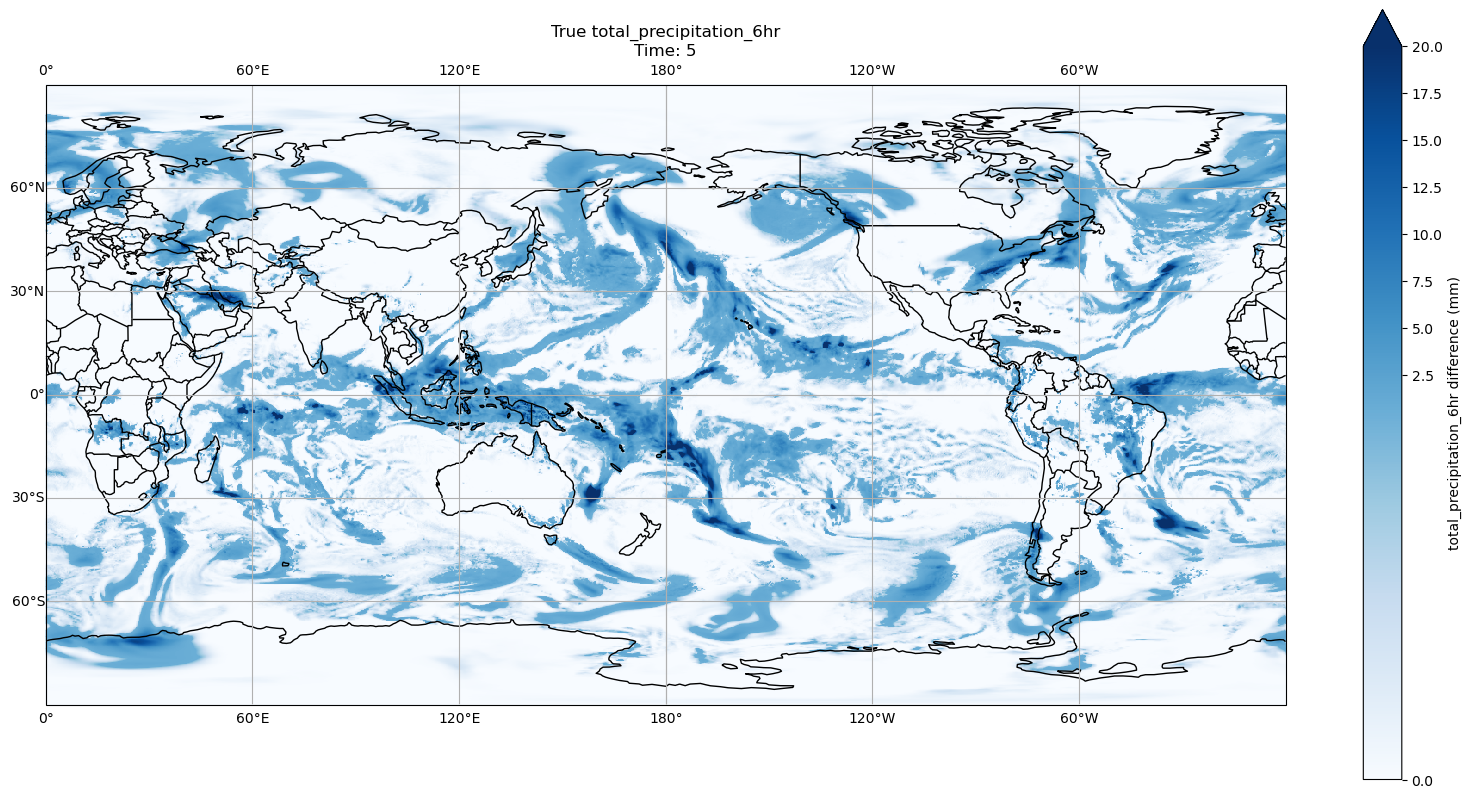

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from multiprocessing import Pool


ERA5 = xr.open_dataset(f'testdata/2022-01-01RR.nc')
google = xr.open_dataset('testdata/source-era5_date-2022-01-01_res-0.25_levels-37_steps-12.nc').drop_vars('toa_incident_solar_radiation')

time_index = 5
dataset = google.isel(time=time_index)
target_var = 'total_precipitation_6hr'

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

lat, lon = np.meshgrid(dataset.lon, dataset.lat)

data = dataset[target_var].squeeze() * 1000

im = ax.pcolormesh(data.lon, data.lat, data, 
                   transform=ccrs.PlateCarree(), 
                   cmap='Blues',
                   norm=TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=20),
                   shading='auto')

cbar = plt.colorbar(im, ax=ax, extend='max', 
                            label=f'{target_var} difference (mm)') 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

flag = 'batch' in ERA5._coord_names

plt.title(f'{flag} {target_var}\nTime: {time_index}')
ax.set_global()
plt.show()

In [25]:
"batch" in ERA5['total_precipitation_6hr'].coords

True

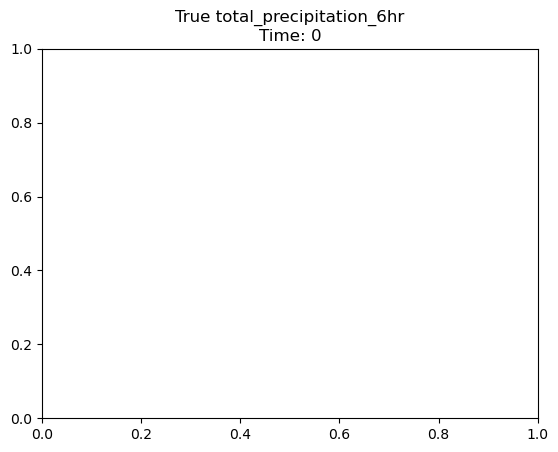

In [4]:
plt.show()
# plt.savefig(f'figure/{flag} {target_var}_{time_index}.png', dpi=300, bbox_inches='tight')
# plt.close()